## Tracking a moving object in 1D
Using Kalman-Filter model specification.
our state space is:

$\mathbf{x}_k = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$,

We model the influence of uncontrolled forces that effect our state space through the acceleration $a_k$, which we model as a constant,
that is $a_k \sim \mathcal{N}(0,\sigma_{a}^2)$.
With Newton's laws of motion:

$\mathbf{x}_k = \underbrace{\begin{bmatrix} 1 & \Delta{t} \\ 0 & 1 \end{bmatrix}}_{\mathbf{F}} \mathbf{x}_{k-1} + \underbrace{\begin{bmatrix} \frac{1}{2}\Delta{t^2} \\ \Delta{t} \end{bmatrix}}_{\mathbf{G}} a_k $

(first row is second order approximation for $x_k$, second row is first order approximation for $\dot{x}_k$

alternatively, 

$\mathbf{x}_k = \mathbf{F}\mathbf{x}_{k-1} + \mathbf{w}_k $

where

$\mathbf{w}_k \sim \mathcal{N}(0,\mathbf{Q})$,

$\mathbf{Q} = \mathbf{G}\mathbf{G}^{T}\sigma_{a}^2 = \begin{bmatrix} \frac{1}{4}\Delta{t^4} & \frac{1}{2}\Delta{t^3} \\ \frac{1}{2}\Delta{t^3} & \Delta{t^2} \end{bmatrix}\sigma_{a}^2$,

Note that the matrix $\mathbf{Q}$ is of rank one (first row = $\frac{1}{2}\Delta_t \ \times$ second row), which means that $\mathbf{w}_k$ has a degenerate distribution. 

In our model script we use `torch.distributions.lowrank_multivariate_normal.
                    LowRankMultivariateNormal` to sample from that object but we cannot evaluate log density - we get `nan`s. Instead, I manually set the log density to be `-200` but it doesn't matter if you use bootsrap particle filter, where proposal = transition.
                    
Our emission simply selects $x$ and adds observation noise

$\mathbf{y}_k = \mathbf{H}\mathbf{x}_k + \mathbf{v}_k$

where 

$\mathbf{H} = \begin{bmatrix} 1 & 0 \end{bmatrix}, \mathbf{v}_k \sim \mathcal{N}(0,\sigma_{v}^2)$

in fact in this simple example, my emission is just 1D:

$y_k = x_k^{(1)} + v_k$



In [1]:
import os
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [2]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state

imported stats


In [3]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import moving_obj_1D # the model script -- distribution objects are defined there

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [43]:
# define global params which we're not ineferring 
transition_scale = 2 # Note: 5 is big balue
emission_scale = 0.2
# proposal_scale_0 = 1
# proposal_scale_t = 0.1
initial_loc = torch.zeros(2)
initial_scale = 1 # * torch.eye(2)
# define train/infer params
num_timesteps = 200
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100
dt = 0.03

In [44]:
initial = moving_obj_1D.Initial(initial_loc, initial_scale)
transition = moving_obj_1D.Transition(dt, transition_scale)
emission = moving_obj_1D.Emission(emission_scale)

In [45]:
# define proposal here
'''we are using the parameters of the initial and transition.'''
proposal = moving_obj_1D.Bootstrap_Proposal(
                        dt, scale_0=initial_scale, 
                                            mu_0 = initial_loc,
                                           scale_t=transition_scale)

In [46]:
np.random.seed(0)
torch.manual_seed(0)

In [47]:
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 2])
torch.Size([10, 1])


In [48]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

torch.Size([10, 2, 200])
torch.Size([10, 1, 200])


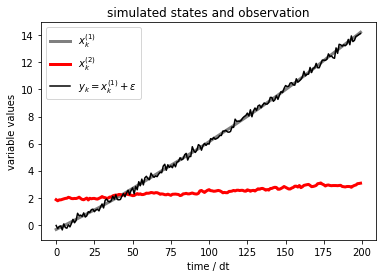

In [131]:
ind_in_batch = 3 # could be between 0 and batch_size-1
plt.plot(lat_data[ind_in_batch,0,:].detach().numpy(), 'gray', 
         label="$x_k^{(1)}$", linewidth = 3);
plt.plot(lat_data[ind_in_batch,1,:].detach().numpy(), 'red', 
         label = "$x_k^{(2)}$", linewidth = 3);
plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), 'black', 
          label = "$y_k= x_k^{(1)} + \epsilon$");#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('simulated states and observation')
plt.ylabel('variable values')
plt.xlabel('time / dt')
plt.legend();
#plt.savefig('first_fig_aesmc.png')

In [82]:
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=100,
            return_log_weights=True,
        )

In [83]:
# extract mean and variance of the latents
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [84]:
# Note: we extracted sim_data and lat_data above
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [85]:
sim_data_np = sim_data.detach().numpy()
smooth_mean_np = smooth_mean.detach().numpy()

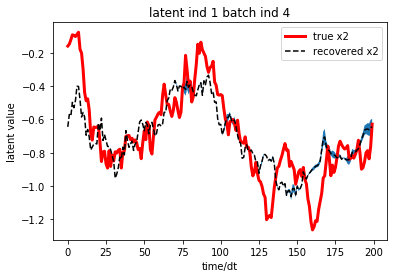

In [134]:
ind_in_batch = 4 # could be between 0 and batch_size-1
dim_lat_plot = 1
plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].\
         detach().numpy(), 'red', linewidth = 3, label= "true x" + 
         str(dim_lat_plot+1));
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].\
         detach().numpy(), 'black', 
         linestyle = 'dashed', label= "recovered x" + 
         str(dim_lat_plot+1));
plt.fill_between(np.arange(200), \
                 smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy() -\
                smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 
                smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy() +\
                smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy()),
plt.title('latent ind ' + str(dim_lat_plot) + 
        ' batch ind ' + str(ind_in_batch))
plt.ylabel('latent value')
plt.xlabel('time/dt')
#plt.ylim([-10,10])
plt.legend();
#plt.savefig('first_fig_aesmc.png')

In [108]:
print(inference_result['log_weights'][-1].shape)
log_weights =  torch.cat([weights.unsqueeze(-1) for
                           weights in inference_result["log_weights"]],
                         dim=2)
ws = log_weights[ind_in_batch,:,:].detach().numpy()
ws.shape

torch.Size([10, 100])


(100, 200)

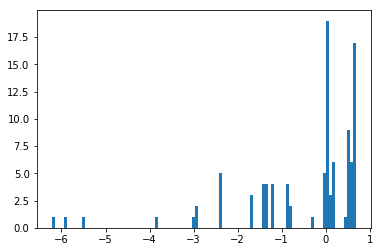

In [90]:
plt.hist(inference_result['log_weights'][-199].
         detach().numpy()[ind_in_batch,:], bins = 100);

In [101]:
x_1 = lat_data[ind_in_batch,0,:].\
         detach().numpy()
x_2 = lat_data[ind_in_batch,1,:].\
         detach().numpy()
print(x_1.shape)

(200,)


In [112]:
expect_x1 = smooth_mean[ind_in_batch,0,:].\
         detach().numpy()
expect_x2 = smooth_mean[ind_in_batch,1,:].\
         detach().numpy()
expect_x1.shape

(200,)

In [100]:
print(inference_result["latents"][-1].shape)
latents_raw =  torch.cat([particles.unsqueeze(-1) for
                           particles in inference_result["latents"]],
                         dim=3)
print(latents_raw.shape)
particles_1 = latents_raw[ind_in_batch, :, 0, :].detach().numpy()
particles_2 = latents_raw[ind_in_batch, :, 1, :].detach().numpy()
print(particles_2.shape)

torch.Size([10, 100, 2, 200])
(100, 200)


/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


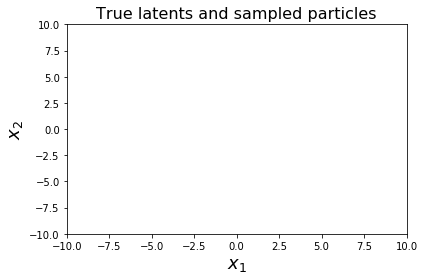

In [128]:
from celluloid import Camera
n_frames = len(x_1)
fig = plt.figure()
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$x_2$", fontsize = 18)
plt.title("True latents and sampled particles", fontsize=16)
#plt.title("(size = importance weight $w_n^{(l)}$)", fontsize=14)
plt.tight_layout()
camera = Camera(fig)
for i in np.arange(0, n_frames, 5): # plot every 5th frame
    plt.scatter(particles_1[:,i], particles_2[:,i], s=ws[:,i]*500, 
                label = "particles", c= "gray", alpha=0.4)
    plt.scatter(x_1[i], x_2[i], marker = '*', s=400, c = 'red', label = "true x")
    plt.scatter(expect_x1[i], expect_x2[i], marker = 'x', s=150, 
                c = 'black', label = "$\mathbb{E}[x|y]$")
    plt.legend(loc= "lower left", labels=["particles","true $x$", 
                                          "$\mathbb{E}[x|y]$"])
    plt.text(0.1,0.05, s= "step " +str(i), fontsize=14, transform=plt.gcf().transFigure)
    plt.text(0.65,0.05, s= "size = log weight", fontsize=14, transform=plt.gcf().transFigure)
    #plt.subplots_adjust(right=0.3)
    camera.snap()
animation = camera.animate()
animation.save("moving_obj_1D_plots/sample_illust.gif", 
               writer='pillow')

In [106]:
particles_1[:,i].shape

(100,)